In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def AND(x1,x2):
    y = 0
    if x1==1 and x2==1:
        y = 1
    return y

def OR(x1,x2):
    y = 0
    if x1==1 or x2==1:
        y = 1
    return y

def NOR1(x1,x2):
    y = 0
    if x1==1 and x2==0:
        y = 1
    return y

def NOR2(x1,x2):
    y = 0
    if x1==0 and x2==1:
        y = 1
    return y

def generate_samples(func):
    x = torch.randint(high=2,size=(1,2))[0]
    y = func(x[0],x[1])
    y = torch.tensor(y).type(torch.float32)
    return x,y

In [23]:
generate_samples(AND)

(tensor([0, 1]), tensor(0.))

Global min:  tensor([0.3434]) tensor([0.3434])


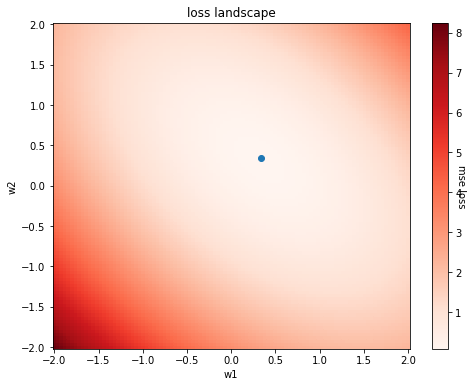

In [24]:
def loss_function(w1, w2, target_func, threshold=0):
    x = [(0,1),
         (1,0),
         (1,1),
         (0,0)]
    
    if type(w1) == torch.tensor:
        loss = torch.zeros(w1.shape)
    else:
        loss = 0
        
    for x1,x2 in x:
        z = x1*w1 + x2*w2
        y_predicted = z
#         y_predicted = torch.maximum(torch.tensor(0),z)
        y_target = target_func(x1,x2)
        loss += (y_target - y_predicted)**2
    
    mse_loss = loss / len(x)
    return mse_loss

def plot_loss_landscape(target_func):
    max_weight = 2
    w1 = torch.linspace(-max_weight, max_weight, 100)
    w2 = torch.linspace(-max_weight, max_weight, 100)

    w1_mesh, w2_mesh = torch.meshgrid(w1, w2)
        
    plt.figure(figsize=(8,6))
    plt.pcolormesh(w1_mesh, w2_mesh,
                   loss_function(w1_mesh, w2_mesh, target_func),
                   shading='nearest',
                   cmap='Reds')
    plt.xlabel('w1')
    plt.ylabel('w2')
    cbar = plt.colorbar()
    cbar.set_label('mse loss', rotation=-90.)
    
    loss_landscape = loss_function(w1_mesh, w2_mesh, target_func)
    global_min = torch.min(loss_landscape)
    min_idx = torch.where(loss_landscape==global_min)
    plt.scatter(w1_mesh[min_idx],w2_mesh[min_idx])
    
    print("Global min: ", w1_mesh[min_idx], w2_mesh[min_idx])

    plt.title('loss landscape')
    plt.show()
    
plot_loss_landscape(AND)

In [25]:
class BinaryClassifier_backprop(nn.Module):
    
    def __init__(self, init_weights, lr, threshold=0):
        super().__init__()
        self.weights = nn.Parameter(init_weights)
        self.threshold = threshold
        
        self.lossCriterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        
        
    def forward(self, x1, x2):
        z = x1*self.weights[0] + x2*self.weights[1]
        y_predicted = (z - self.threshold)
#         y_predicted = torch.maximum(z,torch.tensor(0))
        return y_predicted
    
    
    def train(self, n_epochs, target_func):
        self.target_func = target_func
        
        self.weight_history = torch.zeros(n_epochs,2)
        self.loss_history = torch.zeros(n_epochs)
        
        for i in range(n_epochs):
            self.weight_history[i] = self.weights.detach()
            
            x, y_target = generate_samples(target_func)
            y_predicted = self.forward(x[0],x[1])
            self.optimizer.zero_grad()
            loss = self.lossCriterion(y_predicted,y_target)           
            loss.backward()
            self.optimizer.step()
            
            self.loss_history[i] = loss.detach()
            

    def plot_loss_landscape(self):
        max_weight = 2
        w1 = torch.linspace(-max_weight, max_weight, 100)
        w2 = torch.linspace(-max_weight, max_weight, 100)

        w1_mesh, w2_mesh = torch.meshgrid(w1, w2)

        fig, ax = plt.subplots(1,2,figsize=(15,5))
        im = ax[0].pcolormesh(w1_mesh, w2_mesh,
                       loss_function(w1_mesh, w2_mesh, self.target_func),
                       shading='nearest',
                       cmap='Reds')
        ax[0].set_xlabel('w1')
        ax[0].set_ylabel('w2')
        ax[0].set_title('loss landscape')
        cbar = fig.colorbar(im, ax=ax[0])
        cbar.set_label('mse loss', rotation=-90.)
        
        loss_landscape = loss_function(w1_mesh, w2_mesh, self.target_func)
        global_min = torch.min(loss_landscape)
        min_idx = torch.where(loss_landscape==global_min)
        ax[0].scatter(w1_mesh[min_idx],w2_mesh[min_idx],color='black') #plot global minimum
        ax[0].plot(self.weight_history[:,0],self.weight_history[:,1],color='blue') #plot learning trajectory
        ax[0].scatter(self.weight_history[0,0],self.weight_history[0,1],color='blue') #plot initial position
        ax[0].scatter(self.weight_history[-1,0],self.weight_history[-1,1],color='red') #plot final position

        ax[1].plot(self.loss_history)
        ax[1].set_xlabel('epochs')
        ax[1].set_ylabel('MSE Loss')
        
        print("Global min: ", w1_mesh[min_idx], w2_mesh[min_idx])
        plt.show()

Final weights:  tensor([ 0.8163, -0.1617])
Global min:  tensor([0.6667]) tensor([-0.3434])


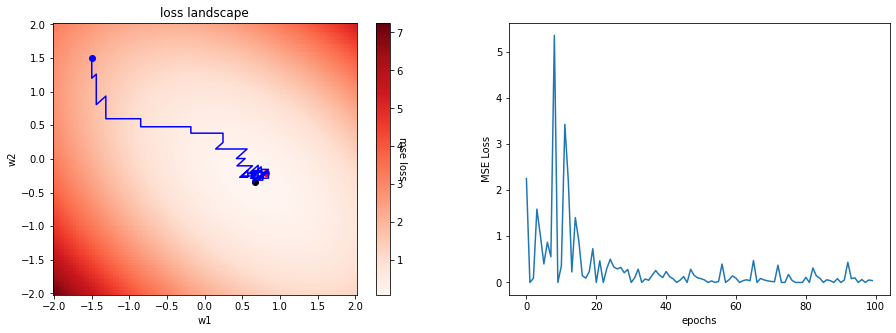

In [26]:
init_weights = torch.tensor([-1.5,1.5])
model = BinaryClassifier_backprop(init_weights, lr=0.1)

model.train(n_epochs=100, target_func=NOR1)
print("Final weights: ", model.weights.detach())

model.plot_loss_landscape()

# Training the same network with BTSP

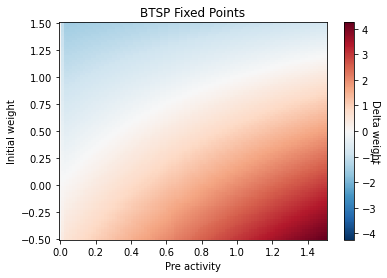

In [27]:
from matplotlib.ticker import MultipleLocator
from scipy import stats

def scaled_single_sigmoid(th, peak, x=None, ylim=None):
    """
    Transform a sigmoid to intersect x and y range limits.
    :param th: float
    :param peak: float
    :param x: array
    :param ylim: pair of float
    :return: callable
    """
    if x is None:
        x = (0., 1.)
    if ylim is None:
        ylim = (0., 1.)
    if th < x[0] or th > x[-1]:
        raise ValueError('scaled_single_sigmoid: th: %.2E is out of range for xlim: [%.2E, %.2E]' % (th, x[0], x[-1]))
    if peak == th:
        raise ValueError('scaled_single_sigmoid: peak and th: %.2E cannot be equal' % th)
    slope = 2. / (peak - th)
    y = lambda x: 1. / (1. + np.exp(-slope * (x - th)))
    start_val = y(x[0])
    end_val = y(x[-1])
    amp = end_val - start_val
    target_amp = ylim[1] - ylim[0]
    return lambda xi: (target_amp / amp) * (1. / (1. + np.exp(-slope * (xi - th))) - start_val) + ylim[0]

tweaked_sigmoid = scaled_single_sigmoid(0.01, 0.02)
def btsp_rule(Pre, Mod, W, Wmax=2., k_pot=1, k_dep=1, k_decay=0.3, weight_decay=False):
    if weight_decay:
        dW = k_pot*(Wmax - W)*Pre*Mod - k_dep*W*tweaked_sigmoid(Pre * Mod) - (k_decay * Pre)# * post)
    else:
        dW = k_pot*(Wmax - W)*Pre*Mod - k_dep*W*tweaked_sigmoid(Pre * Mod)
#     else:
#         out = k_pot*(I*Wmax - W)*E - I*k_dep*W*tweaked_sigmoid(E*I)
    return dW


learning_rate = 0.25
input_peak_rate = 2.0

pre = np.linspace(-0., 1.5, 100)
w0 = np.linspace(-0.5, 1.5, 100)

pre_mesh, w0_mesh = np.meshgrid(pre, w0)
plt.figure()
minmax = np.max(np.abs(btsp_rule(pre_mesh, Mod=1, W=w0_mesh)))
plt.pcolormesh(pre_mesh, w0_mesh,
               btsp_rule(pre_mesh, Mod=1, W=w0_mesh),
               cmap='RdBu_r', shading='nearest',
               vmin=-minmax,vmax=minmax)
plt.xlabel('Pre activity')
plt.ylabel('Initial weight')
cbar = plt.colorbar()
cbar.set_label('Delta weight', rotation=-90.)
plt.title('BTSP Fixed Points')

# plt.plot([0,1,1,0,0],[0,0,1,1,0],color="black") # "normal" range for BTSP rule

plt.show()

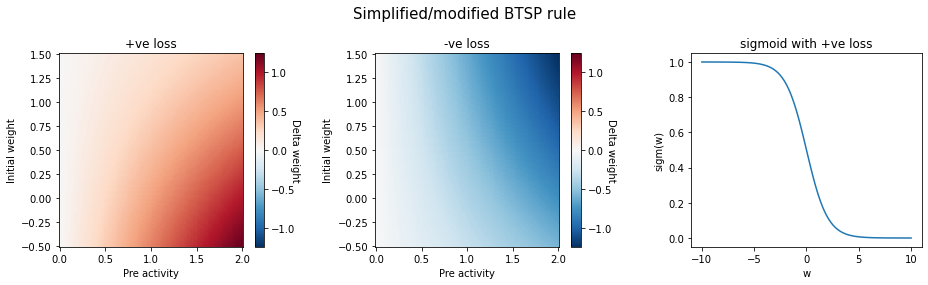

In [94]:
def sigm(x,loss_sign=1):
    return 1/(1+np.exp(x*loss_sign))

def simple_BTSP_rule(Pre, Mod, W, lr,loss=-1):
    Wmax = 1.
#     dW = lr * Mod * (loss*Pre - W)
#     dW = loss * pre * np.abs(1 - W/(pre+0.01))
    dW = loss * pre * sigm(W,np.sign(loss)) * Mod
    if Mod == -1:
        dW = -lr*Pre
    return dW


pre = np.linspace(-0., 2, 100)
w0 = np.linspace(-0.5, 1.5, 100)
pre_mesh, w0_mesh = np.meshgrid(pre, w0)

fig, ax = plt.subplots(1,3,figsize=(13,4))

minmax = np.max(np.abs(simple_BTSP_rule(pre_mesh, Mod=1, W=w0_mesh,lr=1,loss=1)))
im = ax[0].pcolormesh(pre_mesh, w0_mesh,
               simple_BTSP_rule(pre_mesh, Mod=1, W=w0_mesh,lr=1,loss=1),
               cmap='RdBu_r', shading='nearest',
               vmin=-minmax, vmax=minmax)
ax[0].set_xlabel('Pre activity')
ax[0].set_ylabel('Initial weight')
ax[0].set_title('+ve loss')
cbar = plt.colorbar(im,ax=ax[0])
cbar.set_label('Delta weight', rotation=-90.)

minmax = np.max(np.abs(simple_BTSP_rule(pre_mesh, Mod=1, W=w0_mesh,lr=1,loss=-1)))
im2 = ax[1].pcolormesh(pre_mesh, w0_mesh,
               simple_BTSP_rule(pre_mesh, Mod=1, W=w0_mesh, lr=1,loss=-1),
               cmap='RdBu_r', shading='nearest',
               vmin=-minmax, vmax=minmax)
ax[1].set_xlabel('Pre activity')
ax[1].set_ylabel('Initial weight')
ax[1].set_title('-ve loss')
cbar = plt.colorbar(im,ax=ax[1])
cbar.set_label('Delta weight', rotation=-90.)

w = np.linspace(-10,10,100)
ax[2].plot(w,sigm(w,1))
ax[2].set_xlabel('w')
ax[2].set_ylabel('sigm(w)')
ax[2].set_title("sigmoid with +ve loss")

# plt.plot([0,1,1,0,0],[0,0,1,1,0],color="black") # "normal" range for BTSP rule

plt.suptitle('Simplified/modified BTSP rule',fontsize=15)
fig.tight_layout(w_pad=2)
plt.show()

In [11]:
class BinaryClassifier_BTSP():    
    '''
    Linear NN classifier with 2 inputs, 1 output (i.e. 2 weights)
    '''
    def __init__(self, init_weights, lr, threshold=0):
        super().__init__()
        self.weights = init_weights
        self.threshold = threshold
        self.lr = lr

        
    def forward(self, x1, x2):
        z = x1*self.weights[0] + x2*self.weights[1]
        y_predicted = z
#         y_predicted = torch.maximum(z,torch.tensor(0))
        return y_predicted
    
    
    def compute_mod(self, y_predicted, y_target, threshold=0.5):
        error = y_target - y_predicted
        
        if error > threshold:
            mod = 1
        elif error < -threshold:
            mod = -1
        else:
            mod = 0
            
        return mod
    
    
    def train(self, n_epochs, target_func):
        self.target_func = target_func
        self.n_epochs = n_epochs
        self.weight_history = torch.zeros(n_epochs,2)
        self.mod_history = torch.zeros(n_epochs)
        self.loss_history = torch.zeros(n_epochs)        
        
        for i in range(n_epochs):
            self.weight_history[i] = self.weights
            
            x, y_target = generate_samples(target_func)
            y_predicted = self.forward(x[0],x[1])
            
            threshold = 0.1
            mod = self.compute_mod(y_predicted, y_target,threshold)
            dW = simple_BTSP_rule(Pre=x, Mod=mod, W=self.weights, lr=self.lr)
            self.weights += dW
            
            mse_loss = torch.mean((y_target - y_predicted)**2)
            self.loss_history[i] = mse_loss
            self.mod_history[i] = mod
            self.threshold = threshold
                        
        
    def plot_loss_landscape(self):
        max_weight = 2
        w1 = torch.linspace(-max_weight, max_weight, 100)
        w2 = torch.linspace(-max_weight, max_weight, 100)

        w1_mesh, w2_mesh = torch.meshgrid(w1, w2)

        fig, ax = plt.subplots(1,3,figsize=(15,5))
        im = ax[0].pcolormesh(w1_mesh, w2_mesh,
                       loss_function(w1_mesh, w2_mesh, self.target_func),
                       shading='nearest',
                       cmap='Reds')
        ax[0].set_xlabel('w1')
        ax[0].set_ylabel('w2')
        ax[0].set_title('loss landscape')
        cbar = fig.colorbar(im, ax=ax[0])
        cbar.set_label('mse loss', rotation=-90.)
        
        loss_landscape = loss_function(w1_mesh, w2_mesh, self.target_func)
        global_min = torch.min(loss_landscape)
        min_idx = torch.where(loss_landscape==global_min)
        ax[0].scatter(w1_mesh[min_idx],w2_mesh[min_idx],color='black') #plot global minimum
        ax[0].plot(self.weight_history[:,0],self.weight_history[:,1],color='magenta') #plot learning trajectory
        ax[0].scatter(self.weight_history[0,0],self.weight_history[0,1],color='magenta') #plot initial position
        ax[0].scatter(self.weight_history[-1,0],self.weight_history[-1,1],color='red') #plot final position

        ax[1].plot(self.loss_history)
        ax[1].set_xlabel('epochs')
        ax[1].set_ylabel('MSE Loss')
        
        ax[2].scatter(range(self.n_epochs),self.mod_history)
        ax[2].set_xlabel('epochs')
        ax[2].set_ylabel('Mod history')
        
        print("Global min: ", w1_mesh[min_idx], w2_mesh[min_idx])
        plt.show()

Final weights:  tensor([-1.8580, -0.9834])
Global min:  tensor([0.6667]) tensor([-0.3434])


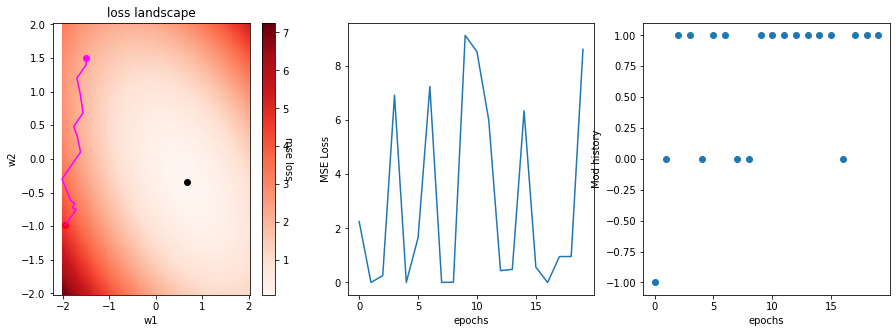

In [13]:
init_weights = torch.tensor([-1.5,1.5])
# init_weights = torch.tensor([1,-1.5])

BTSP_model = BinaryClassifier_BTSP(init_weights, lr=0.1)

BTSP_model.train(n_epochs=20, target_func=NOR1)
print("Final weights: ", BTSP_model.weights)
BTSP_model.plot_loss_landscape()

Final weights:  tensor([0.9917, 0.2028])
Global min:  tensor([0.6667]) tensor([-0.3434])


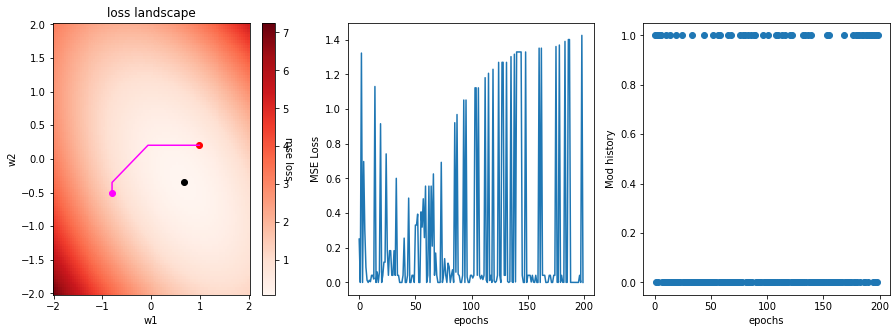

In [65]:
# Without negative mods
def btsp_rule2(Pre, Mod, W, Wmax=1):
#     dW = Mod*Pre*(Wmax - W) - W*tweaked_sigmoid(Pre * Mod)
    dW = Mod*Pre*(Wmax - W)
    return dW


class BinaryClassifier_BTSP2():    
    '''
    Linear NN classifier with 2 inputs, 1 output (i.e. 2 weights)
    '''
    def __init__(self, init_weights, lr, threshold=0):
        super().__init__()
        self.weights = init_weights
        self.threshold = threshold
        self.lr = lr

        
    def forward(self, x1, x2):
        z = x1*self.weights[0] + x2*self.weights[1]
        y_predicted = z
#         y_predicted = torch.maximum(z,torch.tensor(0))
        return y_predicted
    
    
    def compute_mod(self, y_predicted, y_target, threshold=0.5):
        error = y_target - y_predicted
        
        if error > threshold:
            mod = 1
        else:
            mod = 0
            
        return mod
    
    
    def train(self, n_epochs, target_func):
        self.target_func = target_func
        self.n_epochs = n_epochs
        self.weight_history = torch.zeros(n_epochs,2)
        self.mod_history = torch.zeros(n_epochs)
        self.loss_history = torch.zeros(n_epochs)        
        
        for i in range(n_epochs):
            self.weight_history[i] = self.weights
            
            x, y_target = generate_samples(target_func)
            y_predicted = self.forward(x[0],x[1])
            
            threshold = 0.
            mod = self.compute_mod(y_predicted, y_target,threshold)
            dW = btsp_rule2(Pre=x, Mod=mod, W=self.weights)
            self.weights += dW * self.lr
            
            mse_loss = torch.mean((y_target - y_predicted)**2)
            self.loss_history[i] = mse_loss
            self.mod_history[i] = mod
            self.threshold = threshold
                        
        
    def plot_loss_landscape(self):
        max_weight = 2
        w1 = torch.linspace(-max_weight, max_weight, 100)
        w2 = torch.linspace(-max_weight, max_weight, 100)

        w1_mesh, w2_mesh = torch.meshgrid(w1, w2)

        fig, ax = plt.subplots(1,3,figsize=(15,5))
        im = ax[0].pcolormesh(w1_mesh, w2_mesh,
                       loss_function(w1_mesh, w2_mesh, self.target_func),
                       shading='nearest',
                       cmap='Reds')
        ax[0].set_xlabel('w1')
        ax[0].set_ylabel('w2')
        ax[0].set_title('loss landscape')
        cbar = fig.colorbar(im, ax=ax[0])
        cbar.set_label('mse loss', rotation=-90.)
        
        loss_landscape = loss_function(w1_mesh, w2_mesh, self.target_func)
        global_min = torch.min(loss_landscape)
        min_idx = torch.where(loss_landscape==global_min)
        ax[0].scatter(w1_mesh[min_idx],w2_mesh[min_idx],color='black') #plot global minimum
        ax[0].plot(self.weight_history[:,0],self.weight_history[:,1],color='magenta') #plot learning trajectory
        ax[0].scatter(self.weight_history[0,0],self.weight_history[0,1],color='magenta') #plot initial position
        ax[0].scatter(self.weight_history[-1,0],self.weight_history[-1,1],color='red') #plot final position

        ax[1].plot(self.loss_history)
        ax[1].set_xlabel('epochs')
        ax[1].set_ylabel('MSE Loss')
        
        ax[2].scatter(range(self.n_epochs),self.mod_history)
        ax[2].set_xlabel('epochs')
        ax[2].set_ylabel('Mod history')
        
        print("Global min: ", w1_mesh[min_idx], w2_mesh[min_idx])
        plt.show()
        
        
#Create model
init_weights = torch.tensor([-0.8,-0.5])

BTSP_model = BinaryClassifier_BTSP2(init_weights, lr=0.1)

BTSP_model.train(n_epochs=200, target_func=NOR1)
print("Final weights: ", BTSP_model.weights)
BTSP_model.plot_loss_landscape()